In [1]:
import pandas as pd
import re
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import nltk
import keras
nltk.download('punkt')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, SimpleRNN, Activation, Input
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import Flatten
from tensorflow.keras import backend as K
from tensorflow.keras.initializers import Orthogonal
from collections import defaultdict
from keras.models import load_model
from nltk.tokenize import sent_tokenize
from wordcloud import STOPWORDS


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
print(tf.__version__)

2.15.0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load Datasets

In [4]:
df = pd.read_csv('/content/drive/MyDrive/train_preprocess.tsv.txt', sep='\t', names=['text', 'label'], header=None)

In [5]:
df.head()

,text,label
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative


In [6]:
df.shape

(11000, 2)

In [7]:
df.label.value_counts()

label
positive    6416
negative    3436
neutral     1148
Name: count, dtype: int64

In [8]:
df.describe()

,text,label
count,11000,11000
unique,10933,3
top,kesal,positive
freq,4,6416


In [9]:
df.drop_duplicates()
df.head()

,text,label
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative


### Convert label into numeric

In [10]:
label2id = {"neutral":0, "positive":1, "negative":2}


for data in [df]:
    data["label"] = data["label"].map(label2id)

In [11]:
df.head()

,text,label
0,warung ini dimiliki oleh pengusaha pabrik tahu...,1
1,mohon ulama lurus dan k212 mmbri hujjah partai...,0
2,lokasi strategis di jalan sumatera bandung . t...,1
3,betapa bahagia nya diri ini saat unboxing pake...,1
4,duh . jadi mahasiswa jangan sombong dong . kas...,2


## Text Normalization

In [12]:
df['text'][0]

'warung ini dimiliki oleh pengusaha pabrik tahu yang sudah puluhan tahun terkenal membuat tahu putih di bandung . tahu berkualitas , dipadu keahlian memasak , dipadu kretivitas , jadilah warung yang menyajikan menu utama berbahan tahu , ditambah menu umum lain seperti ayam . semuanya selera indonesia . harga cukup terjangkau . jangan lewatkan tahu bletoka nya , tidak kalah dengan yang asli dari tegal !'

In [13]:
len(df['text'][0].split(' '))

66

In [14]:
def count_word(text):
    list_of_text = text.split(' ')
    n_words = len(list_of_text)
    return n_words

df['text'].apply(count_word)

0        66
1        17
2        33
3        17
4        38
         ..
10995     2
10996    26
10997     5
10998    13
10999    68
Name: text, Length: 11000, dtype: int64

In [15]:
for data in [df]:
    data['word_count'] = data['text'].apply(count_word)

df.head()

,text,label,word_count
0,warung ini dimiliki oleh pengusaha pabrik tahu...,1,66
1,mohon ulama lurus dan k212 mmbri hujjah partai...,0,17
2,lokasi strategis di jalan sumatera bandung . t...,1,33
3,betapa bahagia nya diri ini saat unboxing pake...,1,17
4,duh . jadi mahasiswa jangan sombong dong . kas...,2,38


In [16]:
def clean_text(text):
    text = text.lower()
    text = re.sub('[^a-zA-z0-9\s]','', text)
    text = re.sub('  +', ' ', text)
    return text


In [17]:
df_kamus_alay = pd.read_csv("/content/drive/MyDrive/new_kamusalay.csv", encoding= 'latin1', header=None)
kamus_alay_map = dict(zip(df_kamus_alay[0], df_kamus_alay[1]))
def alay_word(text):
    return ' '.join([kamus_alay_map[word] if word in kamus_alay_map else word for word in text.split(' ')])

In [18]:
def processed_text(text):
    text = clean_text(text)
    text = alay_word(text)
    return text

In [19]:
for data in [df]:
    data['text_clean'] = data['text'].apply(processed_text)

df.head()

,text,label,word_count,text_clean
0,warung ini dimiliki oleh pengusaha pabrik tahu...,1,66,warung ini dimiliki oleh pengusaha pabrik tahu...
1,mohon ulama lurus dan k212 mmbri hujjah partai...,0,17,mohon ulama lurus dan k212 mmbri hujjah partai...
2,lokasi strategis di jalan sumatera bandung . t...,1,33,lokasi strategis di jalan sumatra bandung temp...
3,betapa bahagia nya diri ini saat unboxing pake...,1,17,betapa bahagia nya diri ini saat unboxing pake...
4,duh . jadi mahasiswa jangan sombong dong . kas...,2,38,aduh jadi mahasiswa jangan sombong dong kasih ...


## Tokenizer

In [20]:
max_features = 100000 # ada brp yg kita simpan
tokenizer = Tokenizer(num_words=max_features, split=' ', lower=True)
tokenizer.fit_on_texts(df['text_clean'].values)
with open('tokenizer.pickle', 'wb') as handle:
  pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
  print("tokenizer.pickle has created!")
X = tokenizer.texts_to_sequences(df['text_clean'].values)
# with open('x_pad_sequence.pickle', 'wb') as handle:
#   pickle.dump(X, handle, protocol=pickle.HIGHEST_PROTOCOL)
#   print("x_pad_sequence.pickle has created!")

vocab_size = len(tokenizer.word_index)
max_len = max(len(x) for x in X)

X = pad_sequences(X, maxlen=max_len)
with open('x_pad_sequence.pickle', 'wb') as handle:
  pickle.dump(X, handle, protocol=pickle.HIGHEST_PROTOCOL)
  print("x_pad_sequence.pickle has created!")

tokenizer.pickle has created!
x_pad_sequence.pickle has created!


In [21]:
X

array([[   0,    0,    0, ...,  462,   19, 2163],
       [   0,    0,    0, ...,  210,    5, 8592],
       [   0,    0,    0, ...,    1,   14,  470],
       ...,
       [   0,    0,    0, ...,    2,  707, 4831],
       [   0,    0,    0, ..., 2933,   31,   11],
       [   0,    0,    0, ...,   13,    1,   31]], dtype=int32)

## Feature Extraction

In [22]:
# # Bag of Words
# bow = CountVectorizer()
# bow.fit(df['text_clean'])
# X = bow.transform(df['text_clean'])

In [23]:
# # TF-IDF
# tfidf = TfidfVectorizer()
# tfidf.fit(df['text_clean'])
# X = tfidf.transform(df['text_clean']).toarray()

## Train & Test Dataset

In [24]:
Y = pd.get_dummies(df['label']).values
with open('y_labels.pickle', 'wb') as handle:
  pickle.dump(Y, handle, protocol=pickle.HIGHEST_PROTOCOL)
  print("y_labels.pickle has created!")

y_labels.pickle has created!


In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.25, random_state = 123)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(8250, 91) (2750, 91)
(8250, 3) (2750, 3)


In [26]:
X_train.shape[1]

91

## StandardScaler

In [27]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [60]:
embed_dim = 100
units_1 = 64
units_2 = 32

model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=max_features, output_dim=embed_dim, input_length=X_train.shape[1]))
model_lstm.add(LSTM(units_1, dropout=0.5, return_sequences=True))
model_lstm.add(LSTM(units_2, dropout=0.5))
model_lstm.add(Dense(3, activation='softmax'))

loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
# es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=30, restore_best_weights=True)

# sgd = tf.keras.optimizers.SGD(learning_rate=0.001)
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
model_lstm.compile(optimizer=adam,
             loss=loss_fn,
             metrics=['accuracy'])

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
model_lstm.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 91, 100)           10000000  
                                                                 
 lstm_12 (LSTM)              (None, 91, 64)            42240     
                                                                 
 lstm_13 (LSTM)              (None, 32)                12416     
                                                                 
 dense_6 (Dense)             (None, 3)                 99        
                                                                 
Total params: 10054755 (38.36 MB)
Trainable params: 10054755 (38.36 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [44]:
epoch = 30
history = model_lstm.fit(X_train, y_train, epochs=epoch, validation_data=(X_test, y_test), callbacks=[es], verbose=2, batch_size=30)

Epoch 1/30
275/275 - 9s - loss: 0.9328 - accuracy: 0.5784 - val_loss: 0.8853 - val_accuracy: 0.5905 - 9s/epoch - 31ms/step
Epoch 2/30
275/275 - 3s - loss: 0.8876 - accuracy: 0.5813 - val_loss: 0.8499 - val_accuracy: 0.5927 - 3s/epoch - 12ms/step
Epoch 3/30
275/275 - 4s - loss: 0.8413 - accuracy: 0.6017 - val_loss: 0.8101 - val_accuracy: 0.6076 - 4s/epoch - 16ms/step
Epoch 4/30
275/275 - 3s - loss: 0.8105 - accuracy: 0.6193 - val_loss: 0.7878 - val_accuracy: 0.6200 - 3s/epoch - 11ms/step
Epoch 5/30
275/275 - 3s - loss: 0.7958 - accuracy: 0.6264 - val_loss: 0.7765 - val_accuracy: 0.6244 - 3s/epoch - 11ms/step
Epoch 6/30
275/275 - 3s - loss: 0.7826 - accuracy: 0.6278 - val_loss: 0.7725 - val_accuracy: 0.6240 - 3s/epoch - 11ms/step
Epoch 7/30
275/275 - 4s - loss: 0.7805 - accuracy: 0.6315 - val_loss: 0.7691 - val_accuracy: 0.6295 - 4s/epoch - 14ms/step
Epoch 8/30
275/275 - 3s - loss: 0.7770 - accuracy: 0.6321 - val_loss: 0.7690 - val_accuracy: 0.6338 - 3s/epoch - 12ms/step
Epoch 9/30
275/2

### Evaluasi

In [61]:
score = model_lstm.evaluate(X_test, y_test, verbose=2)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

69/69 - 2s - loss: 1.0994 - accuracy: 0.3559 - 2s/epoch - 23ms/step
Test Score: 1.0993622541427612
Test Accuracy: 0.3559090793132782


In [31]:
predictions = model_lstm.predict(X_test)
y_pred = predictions
matrix_test = metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print("Testing selesai")
print(matrix_test)

86/86 [==============================] - 1s 4ms/step
Testing selesai
              precision    recall  f1-score   support

           0       0.55      0.35      0.43       272
           1       0.71      0.81      0.76      1624
           2       0.46      0.39      0.42       854

    accuracy                           0.64      2750
   macro avg       0.58      0.52      0.54      2750
weighted avg       0.62      0.64      0.62      2750



### Predict dan kalkulasi

In [32]:
# y_pred = model_lstm.predict(X_test)
# y_pred_classes = np.argmax(y_pred, axis=1)
# y_true = np.argmax(y_test, axis=1)
# print("Accuracy Score:", accuracy_score(y_true, y_pred_classes))

### Plot 'Accuracy'


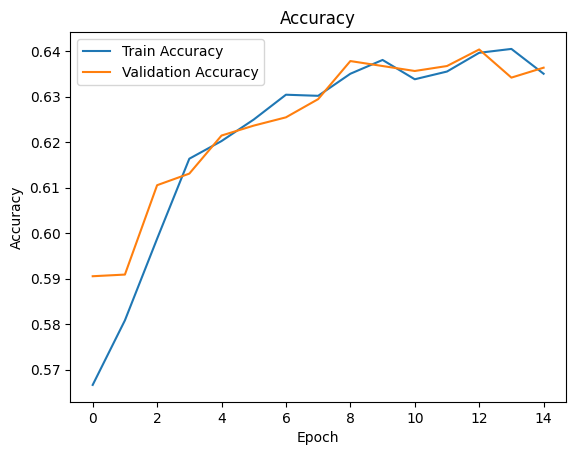

In [33]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Plot 'Loss'

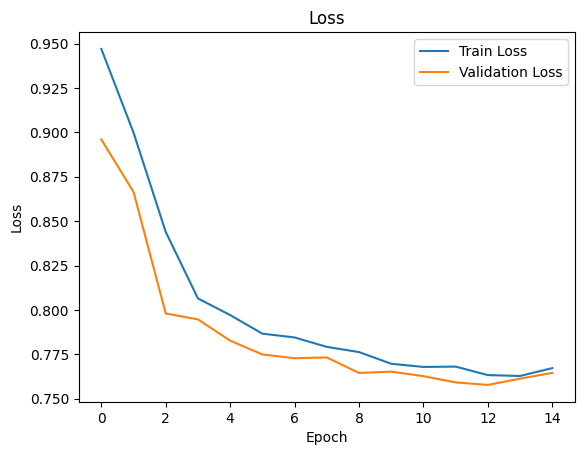

In [34]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [46]:
# model_lstm.save('my_lstm_model.keras', save_format='keras')
model_lstm.save('my_lstm_model.h5')
print("Model has created!")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model has created!


In [36]:
# with open('lstm.pickle', 'wb') as handle:
#   pickle.dump(model_lstm, handle, protocol=pickle.HIGHEST_PROTOCOL)
#   print("lstm.pickle has created!")

## Cross Val

In [50]:
kf = KFold(n_splits=5, random_state=42, shuffle=True)

scores = []
fold = []

# for idx, (train_idx, test_idx) in enumerate(kf.split(X), start=1):
#     X_train, X_test = X[train_idx], X[test_idx]
#     y_train, y_test = Y[train_idx], Y[test_idx]

#     knn_k = KNeighborsClassifier(n_neighbors=13, metric='l2')
#     knn_k.fit(X_train, y_train)
#     y_pred = knn_k.predict(X_test)
#     score = accuracy_score(y_test, y_pred)
#     scores.append(score)
#     fold.append(idx)

for idx, (train_idx, test_idx) in enumerate(kf.split(X), start=1):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = Y[train_idx], Y[test_idx]

    # Create a new instance of the model for each fold
    cv_lstm = model_lstm

    # Train the model
    cv_lstm.fit(X_train, y_train, epochs=10, batch_size=64, verbose=0)

    # Evaluate the model
    y_pred = cv_lstm.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)

    score = accuracy_score(y_test_classes, y_pred_classes)
    scores.append(score)
    fold.append(idx)

69/69 [==============================] - 0s 5ms/step


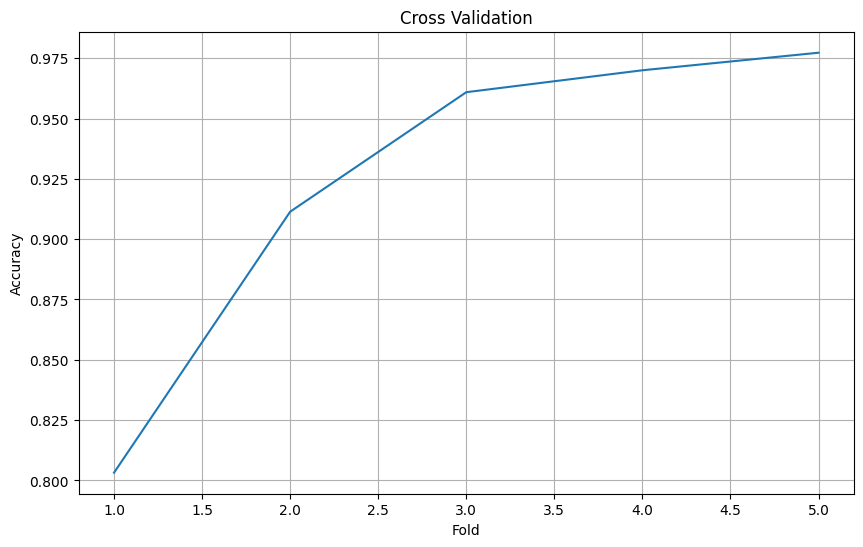

In [51]:
plt.figure(figsize=(10,6))
plt.title("Cross Validation")
plt.plot(fold, scores)
plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.grid()
plt.show()

## Predict PPT BINAR

In [47]:
input_text = """
tolol.
"""

def cleansing(sent):
  string = sent.lower()
  string = re.sub(r'[^a-zA-Z0-9]', ' ', string)
  return string

In [48]:
sentiment = {0: 'neutral', 1: 'positive', 2: 'negative'}

text = [cleansing(input_text)]
predicted = tokenizer.texts_to_sequences(text)
guess = pad_sequences(predicted, maxlen=max_len) #X.shape[1]

# file_lstm = open('lstm.pickle','rb')
model = load_model('my_lstm_model.h5')
prediction = model.predict(guess)
print("Raw Predictions:", prediction)
# polarity = np.argmax(prediction[0])

# print("Text: ",text[0])
# print("Sentiment: ",sentiment[polarity])

1/1 [==============================] - 1s 605ms/step
Raw Predictions: [[0.06197681 0.5962657  0.34175748]]


In [49]:
polarity = np.argmax(prediction[0])

# if polarity == 0:
#   sentimen_label = "neutral"
# elif polarity == 1:
#   sentiment_label = "positive"
# elif polarity == 2:
#   sentiment_label = "negative"

sentiment_label = sentiment[polarity]

print("Text: ",text[0])
print("Sentiment: ", sentiment_label)

Text:   tolol  
Sentiment:  positive


In [40]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print(classification_report(y_true, y_pred_classes, target_names=['neutral', 'positive', 'negative']))

86/86 [==============================] - 1s 5ms/step
              precision    recall  f1-score   support

     neutral       0.55      0.35      0.43       272
    positive       0.71      0.81      0.76      1624
    negative       0.46      0.39      0.42       854

    accuracy                           0.64      2750
   macro avg       0.58      0.52      0.54      2750
weighted avg       0.62      0.64      0.62      2750



ini sudah saya coba berkali" train model, tetapi masih tetep accuracynya 63%, pdhl cuma nambahin hidden layer, sebelumnya masih bisa predict negative sm positive, ini jd positive semua :"

sy update malah 30% :"


In [41]:
# threshold = 0.5
# polarity = np.argmax(prediction[0])

# if prediction[0][1] > threshold:  # Assuming 1 corresponds to 'positive'
#     print("Text: ", text[0])
#     print("Sentiment: positive")
# elif prediction[0][2] > threshold:  # Assuming 2 corresponds to 'negative'
#     print("Text: ", text[0])
#     print("Sentiment: negative")
# else:
#     print("Text: ", text[0])
#     print("Sentiment: ", sentiment[polarity])

In [42]:
# evaluation = model.evaluate(X_test, y_test)
# print("Evaluation Loss:", evaluation[0])
# print("Evaluation Accuracy:", evaluation[1])